# G1 Übung: Bildverarbeitung (Binomial Blur + Sobel) & SLP auf MNIST
Dieses Notebook führt zwei Hauptteile aus:
1. Bildverarbeitungsschritte: Binomial-Filter, Sobel-Gradienten, Magnitude & Orientierungs-Histogramme (global und quadrant-basiert).
2. Einfacher Single Layer Perceptron (SLP) zur Klassifikation von MNIST-Ziffern.

## 1. Imports & Grundeinstellungen

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image, ImageOps
from types import SimpleNamespace

# Reproducibility (optional)
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
device = ('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## 2. Bild laden & Graustufen-Konvertierung

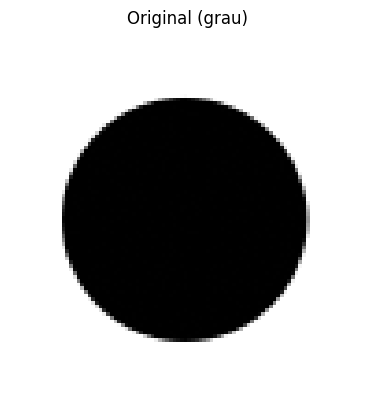

Pixelwert an (50, 50): 255


In [ ]:
# Versuche die Datei relativ zum Notebook zu laden.
img_path_candidates = [Path('../SchwarzerKreis.png'), Path('SchwarzerKreis.png')]
img_path = None
for p in img_path_candidates:
    if p.exists():
        img_path = p
        break
if img_path is None:
    raise FileNotFoundError('SchwarzerKreis.png nicht gefunden (prüfe Pfad).')

img = Image.open(img_path)
img = ImageOps.grayscale(img)
plt.imshow(img, cmap='gray')
plt.title('Original (grau)')
plt.axis('off')
plt.show()

## 3. Binomial-Filter anwenden (Weichzeichnung)

Batch shape: torch.Size([6, 1, 100, 96])
Blurred shape: torch.Size([1, 1, 100, 96])


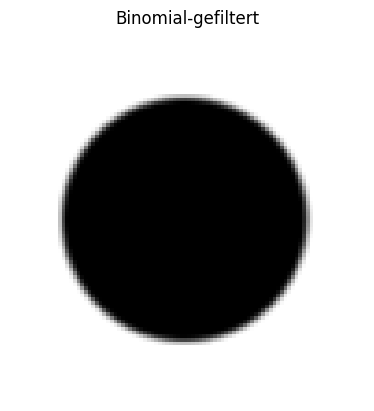

In [15]:
# Definition der Filtergewichte (Sobel & Binomial)
GxWeights = np.array([[ -0.25, 0.0,  0.25],
                      [ -0.50, 0.0,  0.50],
                      [ -0.25, 0.0,  0.25]], dtype=np.float32)
GyWeights = np.array([[ -0.25, -0.50, -0.25],
                      [  0.00,  0.00,  0.00],
                      [  0.25,  0.50,  0.25]], dtype=np.float32)
BinomialWeights = np.array([[0.0625, 0.125, 0.0625],
                            [0.1250, 0.250, 0.1250],
                            [0.0625, 0.125, 0.0625]], dtype=np.float32)

# Bild -> Tensor (C,H,W)
transform = transforms.ToTensor()
img_tensor = transform(img)  # shape (1,H,W)

# Binomial-Kernel als Conv2d (Padding=replicate für Randbehandlung wie angegeben)
blur_conv = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False, padding_mode='replicate')
with torch.no_grad():
    blur_conv.weight.copy_(torch.from_numpy(BinomialWeights).unsqueeze(0).unsqueeze(0))

img_blur = blur_conv(img_tensor.unsqueeze(0))  # shape (1,1,H,W)
print('Blurred shape:', img_blur.shape)

plt.imshow(img_blur[0,0].detach().numpy(), cmap='gray')
plt.title('Binomial-gefiltert')
plt.axis('off')
plt.show()

# 3.1 Multiple images

Batch Blurred shape: torch.Size([6, 1, 100, 96])


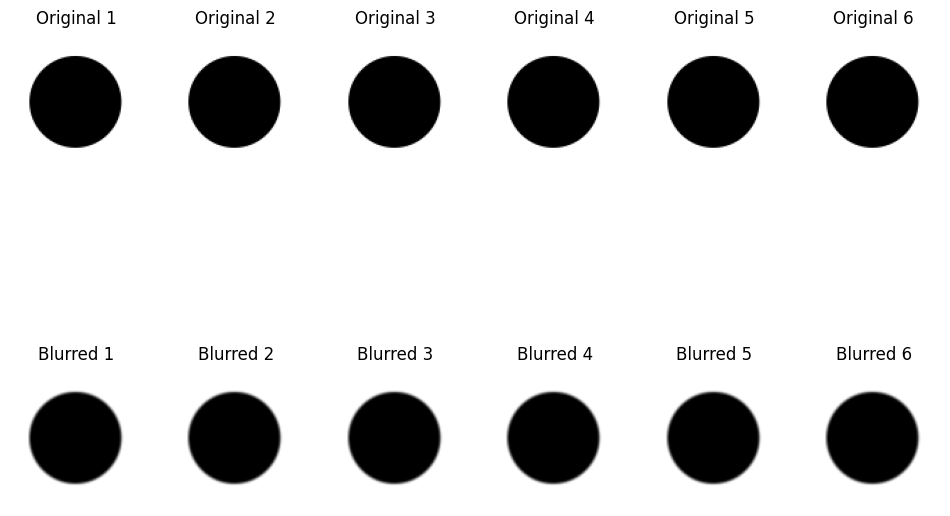

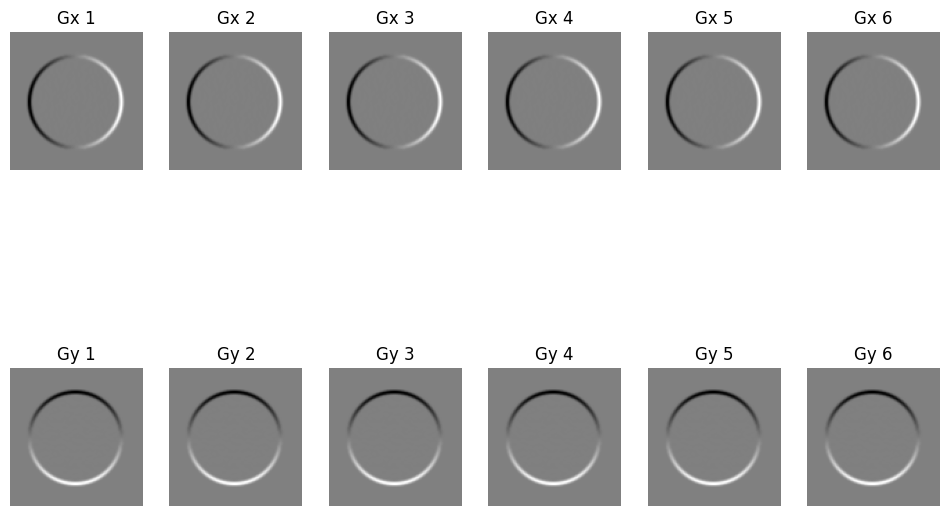

In [ ]:
imgNameList = ['SchwarzerKreis.png', 'SchwarzerKreis.png', 'SchwarzerKreis.png', 'SchwarzerKreis.png', 'SchwarzerKreis.png', 'SchwarzerKreis.png']
imgList = []

for item in imgNameList:
    newImage = Image.open(item)
    newImage = ImageOps.grayscale(newImage)
    imageNewTensor = transform(newImage)
    imageNewTensor = imageNewTensor.unsqueeze(0)  # shape (1,1,H,W)
    imgList.append(imageNewTensor)

imagesNewBatch = torch.cat(imgList, dim=0)  # shape (N,1,H,W)

blurConv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False, padding_mode='replicate')

with torch.no_grad():
    blurConv.state_dict()['weight'].copy_(torch.from_numpy(BinomialWeights).unsqueeze(0).unsqueeze(0))

imagesNewBatchBlur = blurConv(imagesNewBatch)  # shape (N,1,H,W)
print('Batch Blurred shape:', imagesNewBatchBlur.shape)

plt.figure(figsize=(12,8))
for i in range(len(imgNameList)):
    plt.subplot(2, len(imgNameList), i+1)
    plt.imshow(imagesNewBatch[i,0].detach().numpy(), cmap='gray')
    plt.title(f'Original {i+1}')
    plt.axis('off')
    
    plt.subplot(2, len(imgNameList), i+1+len(imgNameList))
    plt.imshow(imagesNewBatchBlur[i,0].detach().numpy(), cmap='gray')
    plt.title(f'Blurred {i+1}')
    plt.axis('off')


sobel_tensorsNew = torch.cat([torch.from_numpy(GxWeights).unsqueeze(0).unsqueeze(0), torch.from_numpy(GyWeights).unsqueeze(0).unsqueeze(0)], dim=0)

conv_sobelNew = nn.Conv2d(1, 2, kernel_size=3, stride=1, padding=1, bias=False, padding_mode='replicate')
with torch.no_grad():
    conv_sobelNew.weight.copy_(sobel_tensorsNew)  # (2,1,3,3)


filteredNew = conv_sobelNew(imagesNewBatchBlur)  # shape (N,2,H,W)

gx_allNew = filteredNew[:,0]        # (N,H,W)
gy_allNew = filteredNew[:,1]        # (N,H,W)

plt.figure(figsize=(12,8))
for i in range(len(imgNameList)):
    plt.subplot(2, len(imgNameList), i+1)
    plt.imshow(gx_allNew[i].detach().numpy(), cmap='gray')
    plt.title(f'Gx {i+1}')
    plt.axis('off')
    
    plt.subplot(2, len(imgNameList), i+1+len(imgNameList))
    plt.imshow(gy_allNew[i].detach().numpy(), cmap='gray')
    plt.title(f'Gy {i+1}')
    plt.axis('off')





## 4. Sobel-Filter & Gradientenberechnung

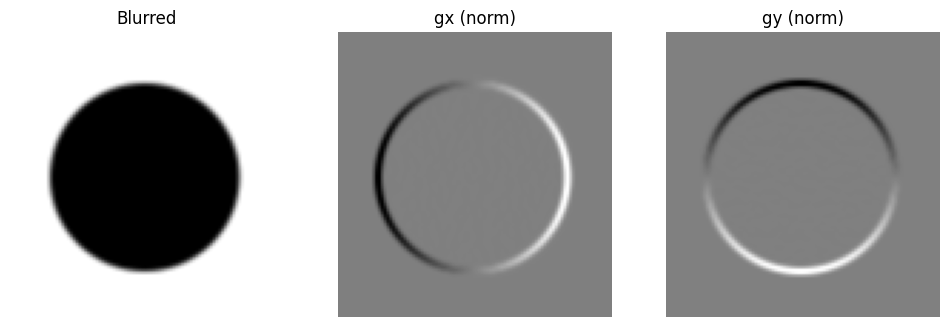

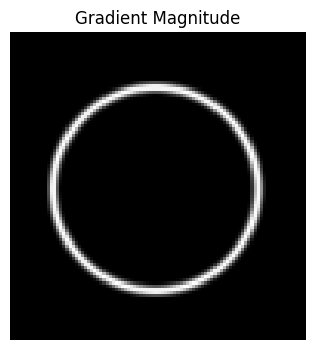

In [ ]:
# Sobel-Filter anwenden (2 Ausgänge: Gx, Gy)
weights_sobel = np.stack([GxWeights, GyWeights], axis=0)  # (2,3,3)
conv_sobel = nn.Conv2d(1, 2, kernel_size=3, stride=1, padding=1, bias=False, padding_mode='replicate')
with torch.no_grad():
    conv_sobel.weight.copy_(torch.from_numpy(weights_sobel).unsqueeze(1))  # (2,1,3,3)
    # conv_sobel.state_dict()['weight'] = torch.from_numpy(weights_sobel).unsqueeze(1)
    # conv_sobel.load_state_dict(conv_sobel.state_dict())

filtered = conv_sobel(img_blur)  # shape (1,2,H,W)
gx = filtered[0,0]  # (H,W)
gy = filtered[0,1]  # (H,W)
mag = torch.sqrt(gx**2 + gy**2)

# Visualisierung der Gradienten-Komponenten (normalisiert)
gx_vis = (0.5 + gx / (2 * gx.abs().max().clamp_min(1e-12))).clamp(0,1)
gy_vis = (0.5 + gy / (2 * gy.abs().max().clamp_min(1e-12))).clamp(0,1)

fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].imshow(img_blur[0,0].detach().numpy(), cmap='gray'); axs[0].set_title('Blurred'); axs[0].axis('off')
axs[1].imshow(gx_vis.detach().numpy(), cmap='gray'); axs[1].set_title('gx (norm)'); axs[1].axis('off')
axs[2].imshow(gy_vis.detach().numpy(), cmap='gray'); axs[2].set_title('gy (norm)'); axs[2].axis('off')
plt.show()

plt.figure(figsize=(4,4))
plt.imshow(mag.detach().numpy(), cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')
plt.show()

## 5. Winkelberechnung & Orientierungs-Histogramm (global)

Anzahl Winkel nach Maskierung: 415


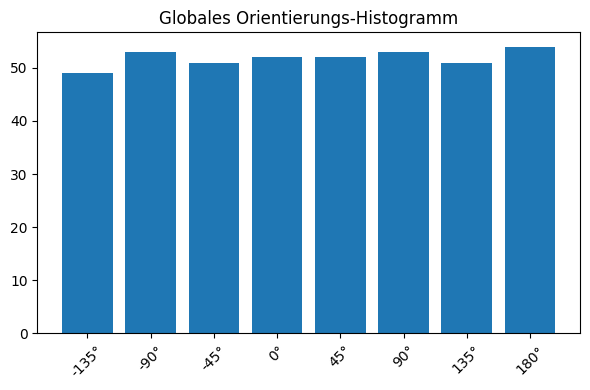

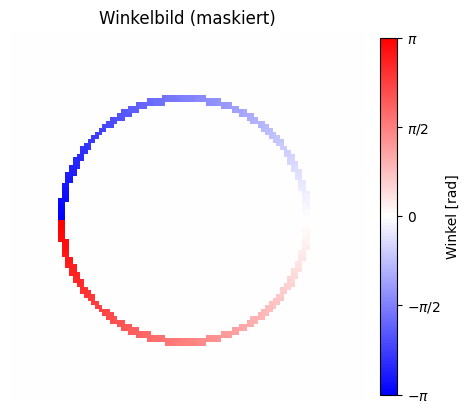

In [6]:
# Winkelbild (atan2)
WinkelInRadians = torch.atan2(gy, gx)  # Bereich [-pi, pi]

# Maske anhand eines Schwellwerts auf der Magnitude
threshold = 0.5
Mask = mag >= threshold
winkelVec = WinkelInRadians[Mask]  # selektierte Winkel
print('Anzahl Winkel nach Maskierung:', winkelVec.numel())

# Funktion zur Erzeugung eines Orientierungs-Histogramms (ähnlich zum Original)
def orientHistFromTensor(tensor_angles: torch.Tensor, num_bins: int):
    offset = np.pi / num_bins
    min_val = -np.pi + offset
    # Periodische Anpassung (vektorisiert)
    adjusted = tensor_angles.clone()
    adjusted[adjusted < min_val] += 2 * np.pi
    hist, bin_edges = torch.histogram(adjusted, bins=num_bins, range=(-np.pi + offset, np.pi + offset))
    return SimpleNamespace(hist=hist, bin_edges=bin_edges)
    

numBins = 8
hist_global = orientHistFromTensor(winkelVec, numBins)

# Balkendiagramm
ypos = np.arange(numBins)
directions = ('-135°', '-90°', '-45°', '0°', '45°', '90°', '135°', '180°')
plt.figure(figsize=(6,4))
plt.bar(ypos, hist_global.hist.detach().numpy())
plt.xticks(ypos, directions, rotation=45)
plt.title('Globales Orientierungs-Histogramm')
plt.tight_layout()
plt.show()

# Winkelbild visualisieren (maskierte Winkel, andere = 0)
winkel_bild = torch.where(Mask, WinkelInRadians, torch.zeros_like(WinkelInRadians))
plt.figure(figsize=(5,5))
im = plt.imshow(winkel_bild.detach().numpy(), cmap='bwr', vmin=-np.pi, vmax=np.pi)
plt.title('Winkelbild (maskiert)')
plt.axis('off')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Winkel [rad]')
cbar.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cbar.set_ticklabels([r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
plt.show()

## 6. Quadranten & lokale Histograms

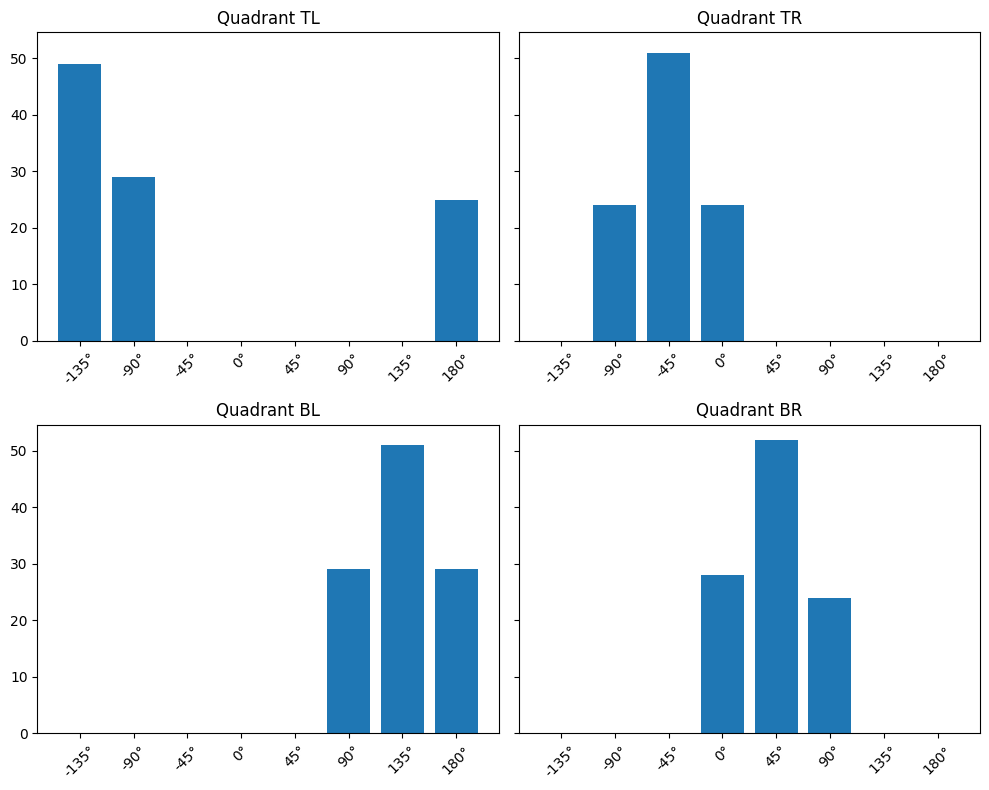

In [7]:
H, W = WinkelInRadians.shape
half_H, half_W = H // 2, W // 2

# Quadranten (Achtung: crop(order) = (top, left, height, width))
TL = WinkelInRadians[:half_H, :half_W]
TR = WinkelInRadians[:half_H, half_W:]
BL = WinkelInRadians[half_H:, :half_W]
BR = WinkelInRadians[half_H:, half_W:]

Mask_TL = Mask[:half_H, :half_W]
Mask_TR = Mask[:half_H, half_W:]
Mask_BL = Mask[half_H:, :half_W]
Mask_BR = Mask[half_H:, half_W:]

winkelVec_TL = TL[Mask_TL]
winkelVec_TR = TR[Mask_TR]
winkelVec_BL = BL[Mask_BL]
winkelVec_BR = BR[Mask_BR]

hist_TL = orientHistFromTensor(winkelVec_TL, numBins)
hist_TR = orientHistFromTensor(winkelVec_TR, numBins)
hist_BL = orientHistFromTensor(winkelVec_BL, numBins)
hist_BR = orientHistFromTensor(winkelVec_BR, numBins)

fig, axes = plt.subplots(2,2, figsize=(10,8), sharey=True)
for ax, h, title in zip(axes.flat, [hist_TL, hist_TR, hist_BL, hist_BR], ['TL','TR','BL','BR']):
    ax.bar(ypos, h.hist.detach().numpy())
    ax.set_xticks(ypos, directions, rotation=45)
    ax.set_title(f'Quadrant {title}')
plt.tight_layout()
plt.show()